<a href="https://colab.research.google.com/github/cchang-vassar/Semantic-Relations-in-Vector-Embeddings/blob/main/study2_7_%5Bada002%5D_scifact_autoencoder_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ada-002] Autoencoder: Generate Corresponding Embedding

## Set Up

### Imports

In [ ]:
!pip install tensorflow

In [ ]:
import os
import subprocess
import zipfile
import shutil
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import userdata
from scipy import spatial
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from plotnine import ggplot, geom_line, aes, ggsave, labs, theme, element_text, guides, guide_legend, scale_color_manual, scale_y_continuous, scale_linetype_manual

### OSF Setup

In [ ]:
!pip install osfclient

In [ ]:
import osfclient.cli

In [ ]:
from osfclient.api import OSF
from osfclient.models import Project, Storage
from io import BytesIO

In [ ]:
os.environ["OSF_USERNAME"] = userdata.get("OSF_USERNAME")
OSF_USERNAME = os.environ["OSF_USERNAME"]

In [ ]:
os.environ["OSF_PASSWORD"] = userdata.get("OSF_PASSWORD")
OSF_PASSWORD = os.environ["OSF_PASSWORD"]

In [ ]:
os.environ["OSF_TOKEN"] = userdata.get("OSF_TOKEN")
OSF_TOKEN = os.environ["OSF_TOKEN"]

In [ ]:
os.environ["OSF_PROJECT_ID"] = userdata.get("OSF_PROJECT_ID")
OSF_PROJECT_ID = os.environ["OSF_PROJECT_ID"]

## Data

### Import corpora data from OSF

In [ ]:
!osf -p sakjg fetch osfstorage/data-dump/ada002-autoencoder/ada_scifact_embeddings_dump.zip

100% 18.5M/18.5M [00:00<00:00, 99.7Mbytes/s]


In [ ]:
embeddings_file_path = 'ada_scifact_embeddings_dump.zip'
output_folder_path = 'current-data-dump/embeddings-dump'
os.makedirs(output_folder_path, exist_ok=True)

with zipfile.ZipFile(embeddings_file_path, 'r') as zip_ref:
  zip_ref.extractall(output_folder_path)

extracted_files = os.listdir(output_folder_path)
print("Files extracted:", extracted_files)

Files extracted: ['training_pro_argument_embeddings.pkl', 'combined_counter_evidence_embeddings.pkl', 'combined_pro_argument_embeddings.pkl', 'combined_pro_evidence_embeddings.pkl', 'training_pro_evidence_embeddings.pkl', 'training_counter_evidence_embeddings.pkl', 'test_counter_argument_embeddings.pkl', 'test_pro_argument_embeddings.pkl', 'combined_counter_argument_embeddings.pkl', 'test_counter_evidence_embeddings.pkl', 'training_counter_argument_embeddings.pkl', 'test_pro_evidence_embeddings.pkl']


### Make dataframes

In [ ]:
x_train_pro = pd.read_pickle('current-data-dump/embeddings-dump/training_pro_argument_embeddings.pkl')
y_train_pro = pd.read_pickle('current-data-dump/embeddings-dump/training_pro_evidence_embeddings.pkl')
x_test_pro = pd.read_pickle('current-data-dump/embeddings-dump/test_pro_argument_embeddings.pkl')
y_test_pro = pd.read_pickle('current-data-dump/embeddings-dump/test_pro_evidence_embeddings.pkl')

In [ ]:
x_train_counter = pd.read_pickle('current-data-dump/embeddings-dump/training_counter_argument_embeddings.pkl')
y_train_counter = pd.read_pickle('current-data-dump/embeddings-dump/training_counter_evidence_embeddings.pkl')
x_test_counter = pd.read_pickle('current-data-dump/embeddings-dump/test_counter_argument_embeddings.pkl')
y_test_counter = pd.read_pickle('current-data-dump/embeddings-dump/test_counter_evidence_embeddings.pkl')

In [ ]:
x_train_pro = x_train_pro.drop(columns=['argument'])
y_train_pro = y_train_pro.drop(columns=['evidence'])
x_test_pro = x_test_pro.drop(columns=['argument'])
y_test_pro = y_test_pro.drop(columns=['evidence'])

In [ ]:
x_train_counter = x_train_counter.drop(columns=['argument'])
y_train_counter = y_train_counter.drop(columns=['evidence'])
x_test_counter = x_test_counter.drop(columns=['argument'])
y_test_counter = y_test_counter.drop(columns=['evidence'])

In [ ]:
x_train_combined = pd.concat([x_train_pro, x_train_counter])
y_train_combined = pd.concat([y_train_pro, y_train_counter])
x_test_combined = pd.concat([x_test_pro, x_test_counter])
y_test_combined = pd.concat([y_test_pro, y_test_counter])

In [ ]:
len(x_train_pro) + len(y_train_pro) + len(x_test_pro) + len(y_test_pro)

912

### Make global data shuffled

In [ ]:
y_train_shuffled = y_train_combined.copy().sample(frac=1).reset_index(drop=True)
y_train_pro_shuffled = y_train_pro.copy().sample(frac=1).reset_index(drop=True)
y_train_counter_shuffled = y_train_counter.copy().sample(frac=1).reset_index(drop=True)

### Save global training df

In [ ]:
x_train_combined_folder_path = 'current-data-dump/ada002-autoencoder/'
x_train_combined_file_path = f'{x_train_combined_folder_path}x_train_combined.pkl'
y_train_combined_folder_path = 'current-data-dump/ada002-autoencoder/'
y_train_combined_file_path = f'{x_train_combined_folder_path}y_train_combined.pkl'
os.makedirs(x_train_combined_folder_path, exist_ok=True)
os.makedirs(y_train_combined_folder_path, exist_ok=True)
with open(x_train_combined_file_path, 'wb') as file:
  pickle.dump(x_train_combined, file)
  print(f"File uploaded to {x_train_combined_file_path}")
with open(y_train_combined_file_path, 'wb') as file:
  pickle.dump(y_train_combined, file)
  print(f"File uploaded to {y_train_combined_file_path}")

File uploaded to current-data-dump/ada002-autoencoder/x_train_combined.pkl
File uploaded to current-data-dump/ada002-autoencoder/y_train_combined.pkl


In [ ]:
x_test_combined_folder_path = 'current-data-dump/ada002-autoencoder/'
x_test_combined_file_path = f'{x_test_combined_folder_path}x_test_combined.pkl'
y_test_combined_folder_path = 'current-data-dump/ada002-autoencoder/'
y_test_combined_file_path = f'{x_test_combined_folder_path}y_test_combined.pkl'
os.makedirs(x_test_combined_folder_path, exist_ok=True)
os.makedirs(y_test_combined_folder_path, exist_ok=True)
with open(x_test_combined_file_path, 'wb') as file:
  pickle.dump(x_test_combined, file)
  print(f"File uploaded to {x_test_combined_file_path}")
with open(y_test_combined_file_path, 'wb') as file:
  pickle.dump(y_test_combined, file)
  print(f"File uploaded to {y_test_combined_file_path}")

File uploaded to current-data-dump/ada002-autoencoder/x_test_combined.pkl
File uploaded to current-data-dump/ada002-autoencoder/y_test_combined.pkl


In [ ]:
x_train_pro_folder_path = 'current-data-dump/ada002-autoencoder/'
x_train_pro_file_path = f'{x_train_pro_folder_path}x_train_pro.pkl'
y_train_pro_folder_path = 'current-data-dump/ada002-autoencoder/'
y_train_pro_file_path = f'{x_train_pro_folder_path}y_train_pro.pkl'
os.makedirs(x_train_pro_folder_path, exist_ok=True)
os.makedirs(y_train_pro_folder_path, exist_ok=True)
with open(x_train_pro_file_path, 'wb') as file:
  pickle.dump(x_train_pro, file)
  print(f"File uploaded to {x_train_pro_file_path}")
with open(y_train_pro_file_path, 'wb') as file:
  pickle.dump(y_train_pro, file)
  print(f"File uploaded to {y_train_pro_file_path}")

File uploaded to current-data-dump/ada002-autoencoder/x_train_pro.pkl
File uploaded to current-data-dump/ada002-autoencoder/y_train_pro.pkl


In [ ]:
x_test_pro_folder_path = 'current-data-dump/ada002-autoencoder/'
x_test_pro_file_path = f'{x_test_pro_folder_path}x_test_pro.pkl'
y_test_pro_folder_path = 'current-data-dump/ada002-autoencoder/'
y_test_pro_file_path = f'{x_test_pro_folder_path}y_test_pro.pkl'
os.makedirs(x_test_pro_folder_path, exist_ok=True)
os.makedirs(y_test_pro_folder_path, exist_ok=True)
with open(x_test_pro_file_path, 'wb') as file:
  pickle.dump(x_test_pro, file)
  print(f"File uploaded to {x_test_pro_file_path}")
with open(y_test_pro_file_path, 'wb') as file:
  pickle.dump(y_test_pro, file)
  print(f"File uploaded to {y_test_pro_file_path}")

File uploaded to current-data-dump/ada002-autoencoder/x_test_pro.pkl
File uploaded to current-data-dump/ada002-autoencoder/y_test_pro.pkl


In [ ]:
x_train_counter_folder_path = 'current-data-dump/ada002-autoencoder/'
x_train_counter_file_path = f'{x_train_counter_folder_path}x_train_counter.pkl'
y_train_counter_folder_path = 'current-data-dump/ada002-autoencoder/'
y_train_counter_file_path = f'{x_train_counter_folder_path}y_train_counter.pkl'
os.makedirs(x_train_counter_folder_path, exist_ok=True)
os.makedirs(y_train_counter_folder_path, exist_ok=True)
with open(x_train_counter_file_path, 'wb') as file:
  pickle.dump(x_train_counter, file)
  print(f"File uploaded to {x_train_counter_file_path}")
with open(y_train_counter_file_path, 'wb') as file:
  pickle.dump(y_train_counter, file)
  print(f"File uploaded to {y_train_counter_file_path}")

File uploaded to current-data-dump/ada002-autoencoder/x_train_counter.pkl
File uploaded to current-data-dump/ada002-autoencoder/y_train_counter.pkl


In [ ]:
x_test_counter_folder_path = 'current-data-dump/ada002-autoencoder/'
x_test_counter_file_path = f'{x_test_counter_folder_path}x_test_counter.pkl'
y_test_counter_folder_path = 'current-data-dump/ada002-autoencoder/'
y_test_counter_file_path = f'{x_test_counter_folder_path}y_test_counter.pkl'
os.makedirs(x_test_counter_folder_path, exist_ok=True)
os.makedirs(y_test_counter_folder_path, exist_ok=True)
with open(x_test_counter_file_path, 'wb') as file:
  pickle.dump(x_test_counter, file)
  print(f"File uploaded to {x_test_counter_file_path}")
with open(y_test_counter_file_path, 'wb') as file:
  pickle.dump(y_test_counter, file)
  print(f"File uploaded to {y_test_counter_file_path}")

File uploaded to current-data-dump/ada002-autoencoder/x_test_counter.pkl
File uploaded to current-data-dump/ada002-autoencoder/y_test_counter.pkl


## Model

### Architecture

In [ ]:
# Layers
input_layer = tf.keras.layers.Input(shape=(1536, ), name="Input")
hidden_layer = tf.keras.layers.Dense(units=1536, activation="relu", name="Hidden")(input_layer)
output_layer = tf.keras.layers.Dense(units=1536, activation="linear", name="Output")(hidden_layer)

In [ ]:
# Model
autoencoder_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1536)]            0         
                                                                 
 Hidden (Dense)              (None, 1536)              2360832   
                                                                 
 Output (Dense)              (None, 1536)              2360832   
                                                                 
Total params: 4721664 (18.01 MB)
Trainable params: 4721664 (18.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Metric

In [ ]:
@tf.keras.saving.register_keras_serializable()
def metric_choose_argument_combined_y_train(y_true, y_pred):
  """combined_metric"""
  combined_training_df_32 = tf.cast(pd.concat([x_train_combined, y_train_combined, x_test_combined, y_test_combined]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(combined_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(combined_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(combined_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(combined_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

In [ ]:
@tf.keras.saving.register_keras_serializable()
def metric_choose_argument_pro_y_train(y_true, y_pred):
  """pro_metric"""
  pro_training_df_32 = tf.cast(pd.concat([x_train_pro, y_train_pro, x_test_pro, y_test_pro]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(pro_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(pro_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(pro_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(pro_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

In [ ]:
@tf.keras.saving.register_keras_serializable()
def metric_choose_argument_counter_y_train(y_true, y_pred):
  """counter_metric"""
  counter_training_df_32 = tf.cast(pd.concat([x_train_counter, y_train_counter, x_test_counter, y_test_counter]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(counter_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(counter_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(counter_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(counter_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

### Combined Training

In [ ]:
# combined Model
combined_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
combined_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_combined_y_train]
)

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='combined_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='combined_training_log.csv', separator=',', append=True)
combined_history = combined_autoencoder_model.fit(
  x=x_train_combined,
  y=y_train_combined,
  batch_size=1,
  epochs=100,
  validation_data = (x_test_combined, y_test_combined),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/100
497/505 [============================>.] - ETA: 0s - loss: -0.8480 - metric_choose_argument_combined_y_train: 0.0121
Epoch 1: saving model to combined_autoencoder_weights.keras
505/505 [==============================] - 9s 7ms/step - loss: -0.8484 - metric_choose_argument_combined_y_train: 0.0139 - val_loss: -0.8776 - val_metric_choose_argument_combined_y_train: 0.0106
Epoch 2/100
504/505 [============================>.] - ETA: 0s - loss: -0.8917 - metric_choose_argument_combined_y_train: 0.1091
Epoch 2: saving model to combined_autoencoder_weights.keras
505/505 [==============================] - 2s 4ms/step - loss: -0.8918 - metric_choose_argument_combined_y_train: 0.1089 - val_loss: -0.8908 - val_metric_choose_argument_combined_y_train: 0.0638
Epoch 3/100
499/505 [============================>.] - ETA: 0s - loss: -0.9102 - metric_choose_argument_combined_y_train: 0.3287
Epoch 3: saving model to combined_autoencoder_weights.keras
505/505 [==============================] - 

In [ ]:
global_history_df = pd.DataFrame(combined_history.history)

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
global_history_df.to_csv(f'{output_folder_path}combined_training_log.csv')

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
combined_autoencoder_model.save(f'{output_folder_path}combined_autoencoder_model.keras')

### Combined Shuffled Training

In [ ]:
# combined Shuffled Model
combined_shuffled_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
combined_shuffled_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_combined_y_train]
)

combined_shuffled_history = combined_shuffled_autoencoder_model.fit(
  x=x_train_combined,
  y=y_train_shuffled,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_combined, y_test_combined)
)

Epoch 1/20
505/505 [==============================] - 5s 7ms/step - loss: -0.8323 - metric_choose_argument_combined_y_train: 0.0020 - val_loss: -0.8558 - val_metric_choose_argument_combined_y_train: 0.0053
Epoch 2/20
505/505 [==============================] - 5s 9ms/step - loss: -0.8596 - metric_choose_argument_combined_y_train: 0.0000e+00 - val_loss: -0.8570 - val_metric_choose_argument_combined_y_train: 0.0000e+00
Epoch 3/20
505/505 [==============================] - 3s 6ms/step - loss: -0.8635 - metric_choose_argument_combined_y_train: 0.0079 - val_loss: -0.8594 - val_metric_choose_argument_combined_y_train: 0.0000e+00
Epoch 4/20
505/505 [==============================] - 3s 5ms/step - loss: -0.8683 - metric_choose_argument_combined_y_train: 0.0059 - val_loss: -0.8582 - val_metric_choose_argument_combined_y_train: 0.0000e+00
Epoch 5/20
505/505 [==============================] - 3s 5ms/step - loss: -0.8746 - metric_choose_argument_combined_y_train: 0.0396 - val_loss: -0.8602 - val_me

In [ ]:
combined_shuffled_history_df = pd.DataFrame(combined_shuffled_history.history)

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
combined_shuffled_history_df.to_csv(f'{output_folder_path}combined_shuffled_training_log.csv')

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
combined_shuffled_autoencoder_model.save(f'{output_folder_path}combined_shuffled_autoencoder_model.keras')

### Pro Training

In [ ]:
# pro Model
pro_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
pro_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_pro_y_train]
)

pro_history = pro_autoencoder_model.fit(
  x=x_train_pro,
  y=y_train_pro,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_pro, y_test_pro)
)

Epoch 1/20
332/332 [==============================] - 3s 5ms/step - loss: -0.8366 - metric_choose_argument_pro_y_train: 0.0030 - val_loss: -0.8695 - val_metric_choose_argument_pro_y_train: 0.0081
Epoch 2/20
332/332 [==============================] - 1s 4ms/step - loss: -0.8823 - metric_choose_argument_pro_y_train: 0.0542 - val_loss: -0.8830 - val_metric_choose_argument_pro_y_train: 0.0484
Epoch 3/20
332/332 [==============================] - 2s 5ms/step - loss: -0.8989 - metric_choose_argument_pro_y_train: 0.3012 - val_loss: -0.8848 - val_metric_choose_argument_pro_y_train: 0.1371
Epoch 4/20
332/332 [==============================] - 4s 11ms/step - loss: -0.9143 - metric_choose_argument_pro_y_train: 0.6054 - val_loss: -0.8907 - val_metric_choose_argument_pro_y_train: 0.1855
Epoch 5/20
332/332 [==============================] - 3s 9ms/step - loss: -0.9276 - metric_choose_argument_pro_y_train: 0.7952 - val_loss: -0.8935 - val_metric_choose_argument_pro_y_train: 0.2097
Epoch 6/20
332/332 

In [ ]:
pro_history_df = pd.DataFrame(pro_history.history)

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
pro_history_df.to_csv(f'{output_folder_path}pro_training_log.csv')

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
pro_autoencoder_model.save(f'{output_folder_path}pro_autoencoder_model.keras')

In [ ]:
# pro Shuffled Model
pro_shuffled_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
pro_shuffled_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_pro_y_train]
)

pro_shuffled_history = pro_shuffled_autoencoder_model.fit(
  x=x_train_pro,
  y=y_train_pro_shuffled,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_pro, y_test_pro)
)

Epoch 1/20
332/332 [==============================] - 3s 6ms/step - loss: -0.8232 - metric_choose_argument_pro_y_train: 0.0000e+00 - val_loss: -0.8502 - val_metric_choose_argument_pro_y_train: 0.0000e+00
Epoch 2/20
332/332 [==============================] - 1s 4ms/step - loss: -0.8595 - metric_choose_argument_pro_y_train: 0.0000e+00 - val_loss: -0.8578 - val_metric_choose_argument_pro_y_train: 0.0000e+00
Epoch 3/20
332/332 [==============================] - 1s 4ms/step - loss: -0.8656 - metric_choose_argument_pro_y_train: 0.0030 - val_loss: -0.8570 - val_metric_choose_argument_pro_y_train: 0.0000e+00
Epoch 4/20
332/332 [==============================] - 1s 4ms/step - loss: -0.8707 - metric_choose_argument_pro_y_train: 0.0301 - val_loss: -0.8577 - val_metric_choose_argument_pro_y_train: 0.0000e+00
Epoch 5/20
332/332 [==============================] - 1s 4ms/step - loss: -0.8796 - metric_choose_argument_pro_y_train: 0.1295 - val_loss: -0.8547 - val_metric_choose_argument_pro_y_train: 0.0

In [ ]:
pro_shuffled_history_df = pd.DataFrame(pro_shuffled_history.history)

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
pro_shuffled_history_df.to_csv(f'{output_folder_path}pro_shuffled_training_log.csv')

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
pro_shuffled_autoencoder_model.save(f'{output_folder_path}pro_shuffled_autoencoder_model.keras')

### Counter Training

In [ ]:
# counter Model
counter_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
counter_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_counter_y_train]
)

counter_history = counter_autoencoder_model.fit(
  x=x_train_counter,
  y=y_train_counter,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_counter, y_test_counter)
)

Epoch 1/20
173/173 [==============================] - 2s 6ms/step - loss: -0.8053 - metric_choose_argument_counter_y_train: 0.0000e+00 - val_loss: -0.8568 - val_metric_choose_argument_counter_y_train: 0.0000e+00
Epoch 2/20
173/173 [==============================] - 1s 6ms/step - loss: -0.8724 - metric_choose_argument_counter_y_train: 0.0231 - val_loss: -0.8686 - val_metric_choose_argument_counter_y_train: 0.0000e+00
Epoch 3/20
173/173 [==============================] - 2s 10ms/step - loss: -0.8930 - metric_choose_argument_counter_y_train: 0.2717 - val_loss: -0.8766 - val_metric_choose_argument_counter_y_train: 0.0469
Epoch 4/20
173/173 [==============================] - 2s 9ms/step - loss: -0.9102 - metric_choose_argument_counter_y_train: 0.6647 - val_loss: -0.8768 - val_metric_choose_argument_counter_y_train: 0.0469
Epoch 5/20
173/173 [==============================] - 1s 6ms/step - loss: -0.9264 - metric_choose_argument_counter_y_train: 0.8208 - val_loss: -0.8807 - val_metric_choose_

In [ ]:
counter_history_df = pd.DataFrame(counter_history.history)

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
counter_history_df.to_csv(f'{output_folder_path}counter_training_log.csv')

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
counter_autoencoder_model.save(f'{output_folder_path}counter_autoencoder_model.keras')

In [ ]:
# counter Shuffled Model
counter_shuffled_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
counter_shuffled_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_counter_y_train]
)

counter_shuffled_history = counter_shuffled_autoencoder_model.fit(
  x=x_train_counter,
  y=y_train_counter_shuffled,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_counter, y_test_counter)
)

Epoch 1/20
173/173 [==============================] - 2s 6ms/step - loss: -0.7931 - metric_choose_argument_counter_y_train: 0.0058 - val_loss: -0.8456 - val_metric_choose_argument_counter_y_train: 0.0000e+00
Epoch 2/20
173/173 [==============================] - 1s 4ms/step - loss: -0.8517 - metric_choose_argument_counter_y_train: 0.0116 - val_loss: -0.8518 - val_metric_choose_argument_counter_y_train: 0.0000e+00
Epoch 3/20
173/173 [==============================] - 1s 4ms/step - loss: -0.8593 - metric_choose_argument_counter_y_train: 0.0000e+00 - val_loss: -0.8548 - val_metric_choose_argument_counter_y_train: 0.0000e+00
Epoch 4/20
173/173 [==============================] - 1s 4ms/step - loss: -0.8695 - metric_choose_argument_counter_y_train: 0.0578 - val_loss: -0.8558 - val_metric_choose_argument_counter_y_train: 0.0000e+00
Epoch 5/20
173/173 [==============================] - 1s 4ms/step - loss: -0.8817 - metric_choose_argument_counter_y_train: 0.2428 - val_loss: -0.8468 - val_metric_

In [ ]:
counter_shuffled_history_df = pd.DataFrame(counter_shuffled_history.history)

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
counter_shuffled_history_df.to_csv(f'{output_folder_path}counter_shuffled_training_log.csv')

In [ ]:
output_folder_path = 'current-data-dump/ada002-autoencoder/'
os.makedirs(output_folder_path, exist_ok=True)
counter_shuffled_autoencoder_model.save(f'{output_folder_path}counter_shuffled_autoencoder_model.keras')

## Export data

In [ ]:
def export_ada_autoencoder():
  """Export ada_autoencoder directory"""
  ada_autoencoder_file_path = 'current-data-dump/ada002-autoencoder'
  ada_autoencoder_file_path_zip = 'current-data-dump/ada002-autoencoder'
  shutil.make_archive(ada_autoencoder_file_path_zip, 'zip', ada_autoencoder_file_path)
  print(f"Zip file created at: {ada_autoencoder_file_path_zip}")
  result = subprocess.run([f"osf -p sakjg upload --force {ada_autoencoder_file_path_zip}.zip data-dump/ada002-scifact-autoencoder/ada002_scifact_autoencoder.zip"], shell=True, capture_output=True, text=True)
  print(result.stderr)
  print(f"File: {ada_autoencoder_file_path_zip} uploaded at osfstorage")

In [ ]:
export_ada_autoencoder()

Zip file created at: current-data-dump/ada002-autoencoder

File: current-data-dump/ada002-autoencoder uploaded at osfstorage


## Import data

In [ ]:
def import_ada_autoencoder():
  """Import ada_autoencoder directory"""
  subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/ada002-scifact-autoencoder/ada002_scifact_autoencoder.zip", shell=True)
  print("ada_autoencoder.zip successfully imported")
  ada_autoencoder_file_path_zip = 'ada002_scifact_autoencoder.zip'
  ada_autoencoder_file_path = 'current-data-dump/ada002-autoencoder'
  os.makedirs(ada_autoencoder_file_path, exist_ok=True)
  with zipfile.ZipFile(ada_autoencoder_file_path_zip, 'r') as zip_ref:
    zip_ref.extractall(ada_autoencoder_file_path)
  extracted_files = os.listdir(ada_autoencoder_file_path)
  print("Files extracted:", extracted_files)

## Load global training history

In [ ]:
import_ada_autoencoder()

ada_autoencoder.zip successfully imported
Files extracted: ['combined_shuffled_training_log.csv', 'pro_training_log.csv', 'counter_training_log.csv', 'counter_training_plot.png', 'x_test_pro.pkl', 'all_shuffled_training_plot.png', 'y_train_combined.pkl', 'counter_shuffled_training_log.csv', 'y_test_combined.pkl', 'y_test_pro.pkl', 'combined_shuffled_training_plot.png', 'pro_shuffled_autoencoder_model.keras', 'combined_autoencoder_model.keras', 'pro_training_plot.png', 'y_train_counter.pkl', 'y_test_counter.pkl', 'y_train_pro.pkl', 'x_train_combined.pkl', 'combined_training_plot.png', 'x_train_counter.pkl', 'counter_shuffled_autoencoder_model.keras', 'x_test_combined.pkl', 'counter_autoencoder_model.keras', 'x_test_counter.pkl', 'pro_autoencoder_model.keras', 'combined_shuffled_autoencoder_model.keras', 'all_training_plot.png', 'combined_training_log.csv', 'x_train_pro.pkl', 'pro_shuffled_training_log.csv']


#### Unshuffled training history

In [ ]:
# Access training history
loaded_combined_history = pd.DataFrame(pd.read_csv("current-data-dump/ada002-autoencoder/combined_training_log.csv"))
loaded_combined_history = pd.melt(loaded_combined_history, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_combined_y_train', 'val_metric_choose_argument_combined_y_train'], var_name='dataset', value_name='accuracy')
loaded_combined_history = loaded_combined_history.replace(['metric_choose_argument_combined_y_train', 'val_metric_choose_argument_combined_y_train'], ['training set', 'validation set'])
loaded_combined_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_combined_history['shuffled'] = False

loaded_pro_history = pd.DataFrame(pd.read_csv("current-data-dump/ada002-autoencoder/pro_training_log.csv"))
loaded_pro_history = pd.melt(loaded_pro_history, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_pro_y_train', 'val_metric_choose_argument_pro_y_train'], var_name='dataset', value_name='accuracy')
loaded_pro_history = loaded_pro_history.replace(['metric_choose_argument_pro_y_train', 'val_metric_choose_argument_pro_y_train'], ['training set', 'validation set'])
loaded_pro_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_pro_history['shuffled'] = False

loaded_counter_history = pd.DataFrame(pd.read_csv("current-data-dump/ada002-autoencoder/counter_training_log.csv"))
loaded_counter_history = pd.melt(loaded_counter_history, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_counter_y_train', 'val_metric_choose_argument_counter_y_train'], var_name='dataset', value_name='accuracy')
loaded_counter_history = loaded_counter_history.replace(['metric_choose_argument_counter_y_train', 'val_metric_choose_argument_counter_y_train'], ['training set', 'validation set'])
loaded_counter_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_counter_history['shuffled'] = False

In [ ]:
linetype_map = {'validation set': 'solid', 'training set': 'dashed'}

all_training_plot = (
    ggplot(loaded_combined_history, aes(x='epoch', y='accuracy', linetype='dataset')) +
    geom_line(size=2) +
    labs(title='Learning Curve of Model Trained on SciFact Data', x='Epoch', y='Accuracy') +
    scale_y_continuous(limits=[0,1]) +
    scale_linetype_manual(linetype_map)+
    theme(
        plot_title=element_text(size=40, lineheight=1.5, wrap=True),
        axis_title=element_text(size=32),
        axis_text=element_text(size=24),
        legend_position='bottom',
        legend_text=element_text(size=24),
        legend_title=element_text(size=32),
        figure_size=[16,24]
        )
)
ggsave(all_training_plot, "current-data-dump/ada002-autoencoder/all_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada002-autoencoder/all_training_plot.png


#### Shuffled training history

In [ ]:
# Access training history
loaded_combined_shuffled_history = pd.DataFrame(pd.read_csv("current-data-dump/ada002-autoencoder/combined_shuffled_training_log.csv"))
loaded_combined_shuffled_history = pd.melt(loaded_combined_shuffled_history, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_combined_y_train', 'val_metric_choose_argument_combined_y_train'], var_name='dataset', value_name='accuracy')
loaded_combined_shuffled_history = loaded_combined_shuffled_history.replace(['metric_choose_argument_combined_y_train', 'val_metric_choose_argument_combined_y_train'], ['training set', 'validation set'])
loaded_combined_shuffled_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_combined_shuffled_history['shuffled'] = True

loaded_pro_shuffled_history = pd.DataFrame(pd.read_csv("current-data-dump/ada002-autoencoder/pro_shuffled_training_log.csv"))
loaded_pro_shuffled_history = pd.melt(loaded_pro_shuffled_history, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_pro_y_train', 'val_metric_choose_argument_pro_y_train'], var_name='dataset', value_name='accuracy')
loaded_pro_shuffled_history = loaded_pro_shuffled_history.replace(['metric_choose_argument_pro_y_train', 'val_metric_choose_argument_pro_y_train'], ['training set', 'validation set'])
loaded_pro_shuffled_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_pro_shuffled_history['shuffled'] = True

loaded_counter_shuffled_history = pd.DataFrame(pd.read_csv("current-data-dump/ada002-autoencoder/counter_shuffled_training_log.csv"))
loaded_counter_shuffled_history = pd.melt(loaded_counter_shuffled_history, id_vars='Unnamed: 0', value_vars=['metric_choose_argument_counter_y_train', 'val_metric_choose_argument_counter_y_train'], var_name='dataset', value_name='accuracy')
loaded_counter_shuffled_history = loaded_counter_shuffled_history.replace(['metric_choose_argument_counter_y_train', 'val_metric_choose_argument_counter_y_train'], ['training set', 'validation set'])
loaded_counter_shuffled_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_counter_shuffled_history['shuffled'] = True

In [ ]:
linetype_map = {'validation set': 'solid', 'training set': 'dashed'}

all_shuffled_training_plot = (
    ggplot(loaded_combined_shuffled_history, aes(x='epoch', y='accuracy', linetype='dataset')) +
    geom_line(size=2) +
    labs(title='Learning Curve of Model Trained on SciFact Data (Shuffled)', x='Epoch', y='Accuracy') +
    scale_y_continuous(limits=[0,1]) +
    scale_linetype_manual(linetype_map)+
    theme(
        plot_title=element_text(size=40, lineheight=1.5, wrap=True),
        axis_title=element_text(size=32),
        axis_text=element_text(size=24),
        legend_position='bottom',
        legend_text=element_text(size=24),
        legend_title=element_text(size=32),
        figure_size=[16,24]
        )
)
ggsave(all_shuffled_training_plot, "current-data-dump/ada002-autoencoder/all_shuffled_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada002-autoencoder/all_shuffled_training_plot.png


## Combined Training Plots

In [ ]:
combined_training_df = pd.concat([loaded_combined_history, loaded_combined_shuffled_history])

In [ ]:
linetype_map = {'validation set': 'solid', 'training set': 'dashed'}

combined_training_plot = (
  ggplot(combined_training_df, aes(x='epoch', y='accuracy', linetype='dataset', color='shuffled')) +
  geom_line(size=2) +
  labs(title='Learning Curve of Model Trained on Unshuffled vs. Within-Topic Shuffled Data', x='Epoch', y='Accuracy') +
  scale_linetype_manual(linetype_map)+
  theme(
    figure_size=(16,24),
    axis_title=element_text(size=32),
    axis_text=element_text(size=24),
    legend_title=element_text(size=32, lineheight=1.5),
    legend_text=element_text(size=24, lineheight=1.5),
    plot_title=element_text(size=40, wrap=True, lineheight=1.5),
    legend_position="bottom",
    legend_key_width=64
  ) +
  guides(fill = guide_legend(byrow = True))
)
ggsave(combined_training_plot, "current-data-dump/ada002-autoencoder/combined_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada002-autoencoder/combined_training_plot.png


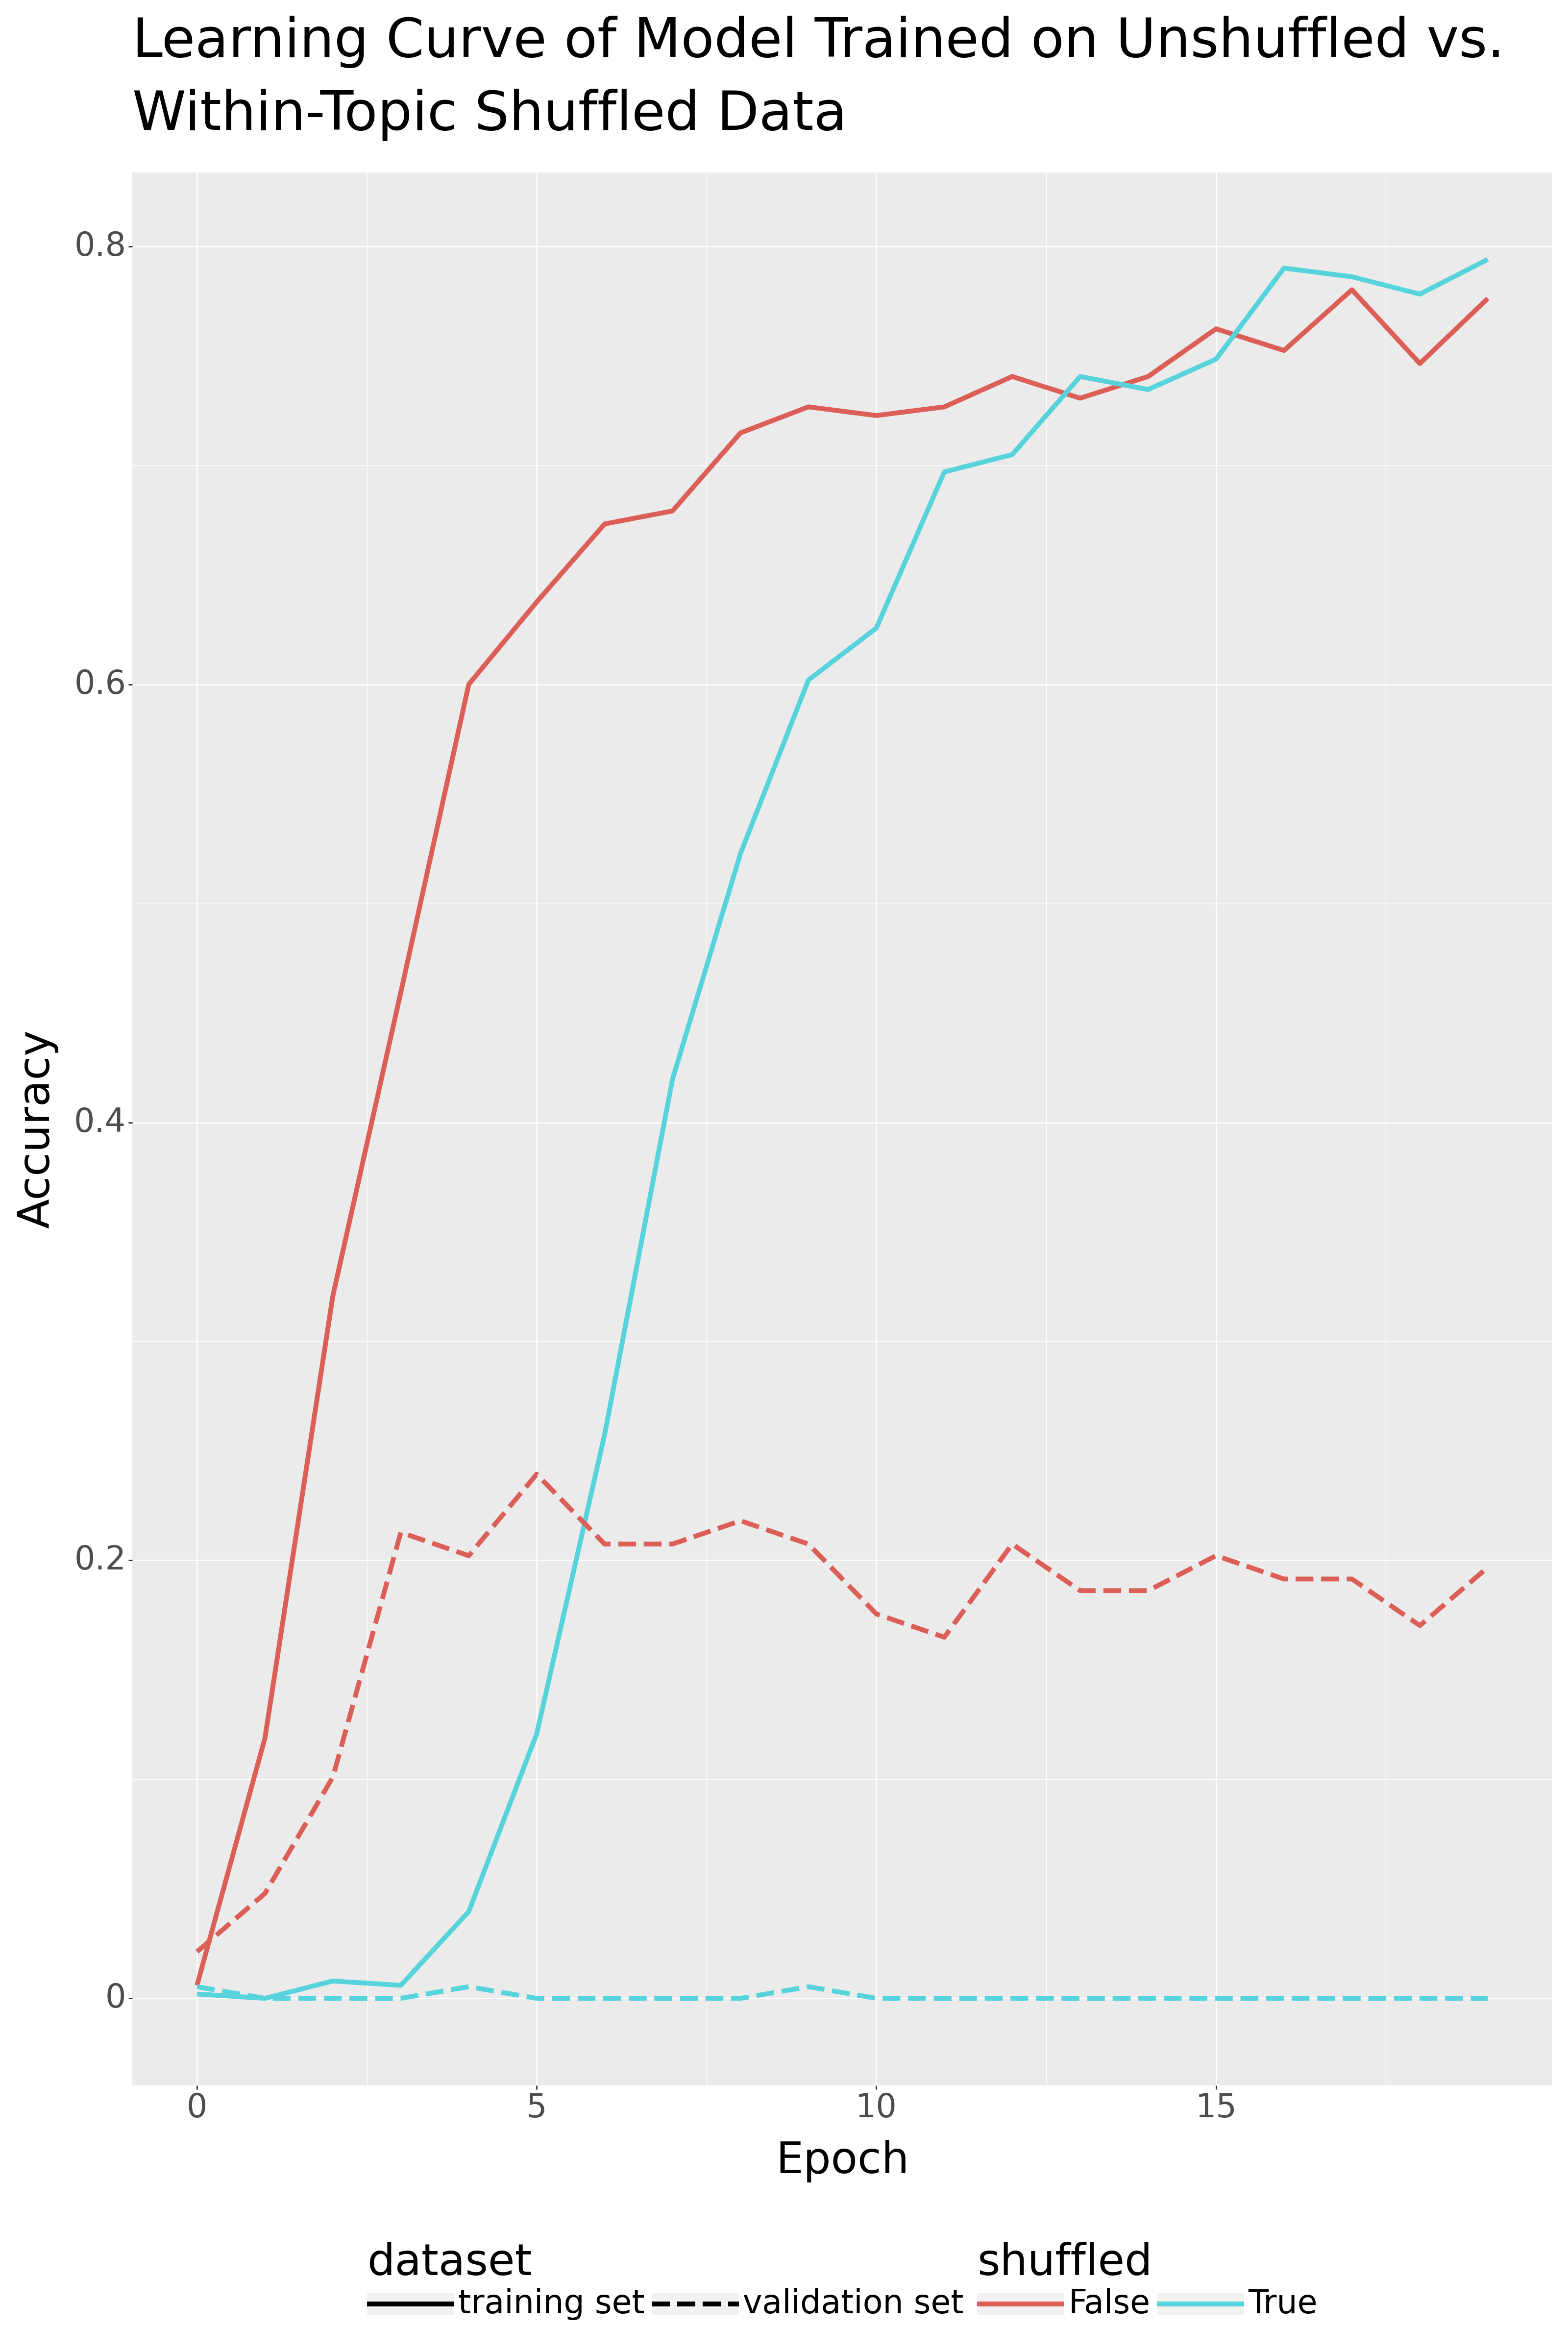

<Figure Size: (1600 x 2400)>

In [ ]:
combined_training_plot

## Pro Training Plots

In [ ]:
pro_training_df = pd.concat([loaded_pro_history, loaded_pro_shuffled_history])

In [ ]:
linetype_map = {'validation set': 'solid', 'training set': 'dashed'}

pro_training_plot = (
  ggplot(pro_training_df, aes(x='epoch', y='accuracy', linetype='dataset', color='shuffled')) +
  geom_line(size=2) +
  labs(title='Learning Curve of Model Trained on Unshuffled vs. Within-Topic Shuffled Data (Pro-evidence Only)', x='Epoch', y='Accuracy') +
  scale_linetype_manual(linetype_map) +
  theme(
    figure_size=(16,24),
    axis_title=element_text(size=32),
    axis_text=element_text(size=24),
    legend_title=element_text(size=32, lineheight=1.5),
    legend_text=element_text(size=24, lineheight=1.5),
    plot_title=element_text(size=40, wrap=True, lineheight=1.5),
    legend_position="bottom",
    legend_key_width=64
  ) +
  guides(fill = guide_legend(byrow = True))
)
ggsave(pro_training_plot, "current-data-dump/ada002-autoencoder/pro_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada002-autoencoder/pro_training_plot.png


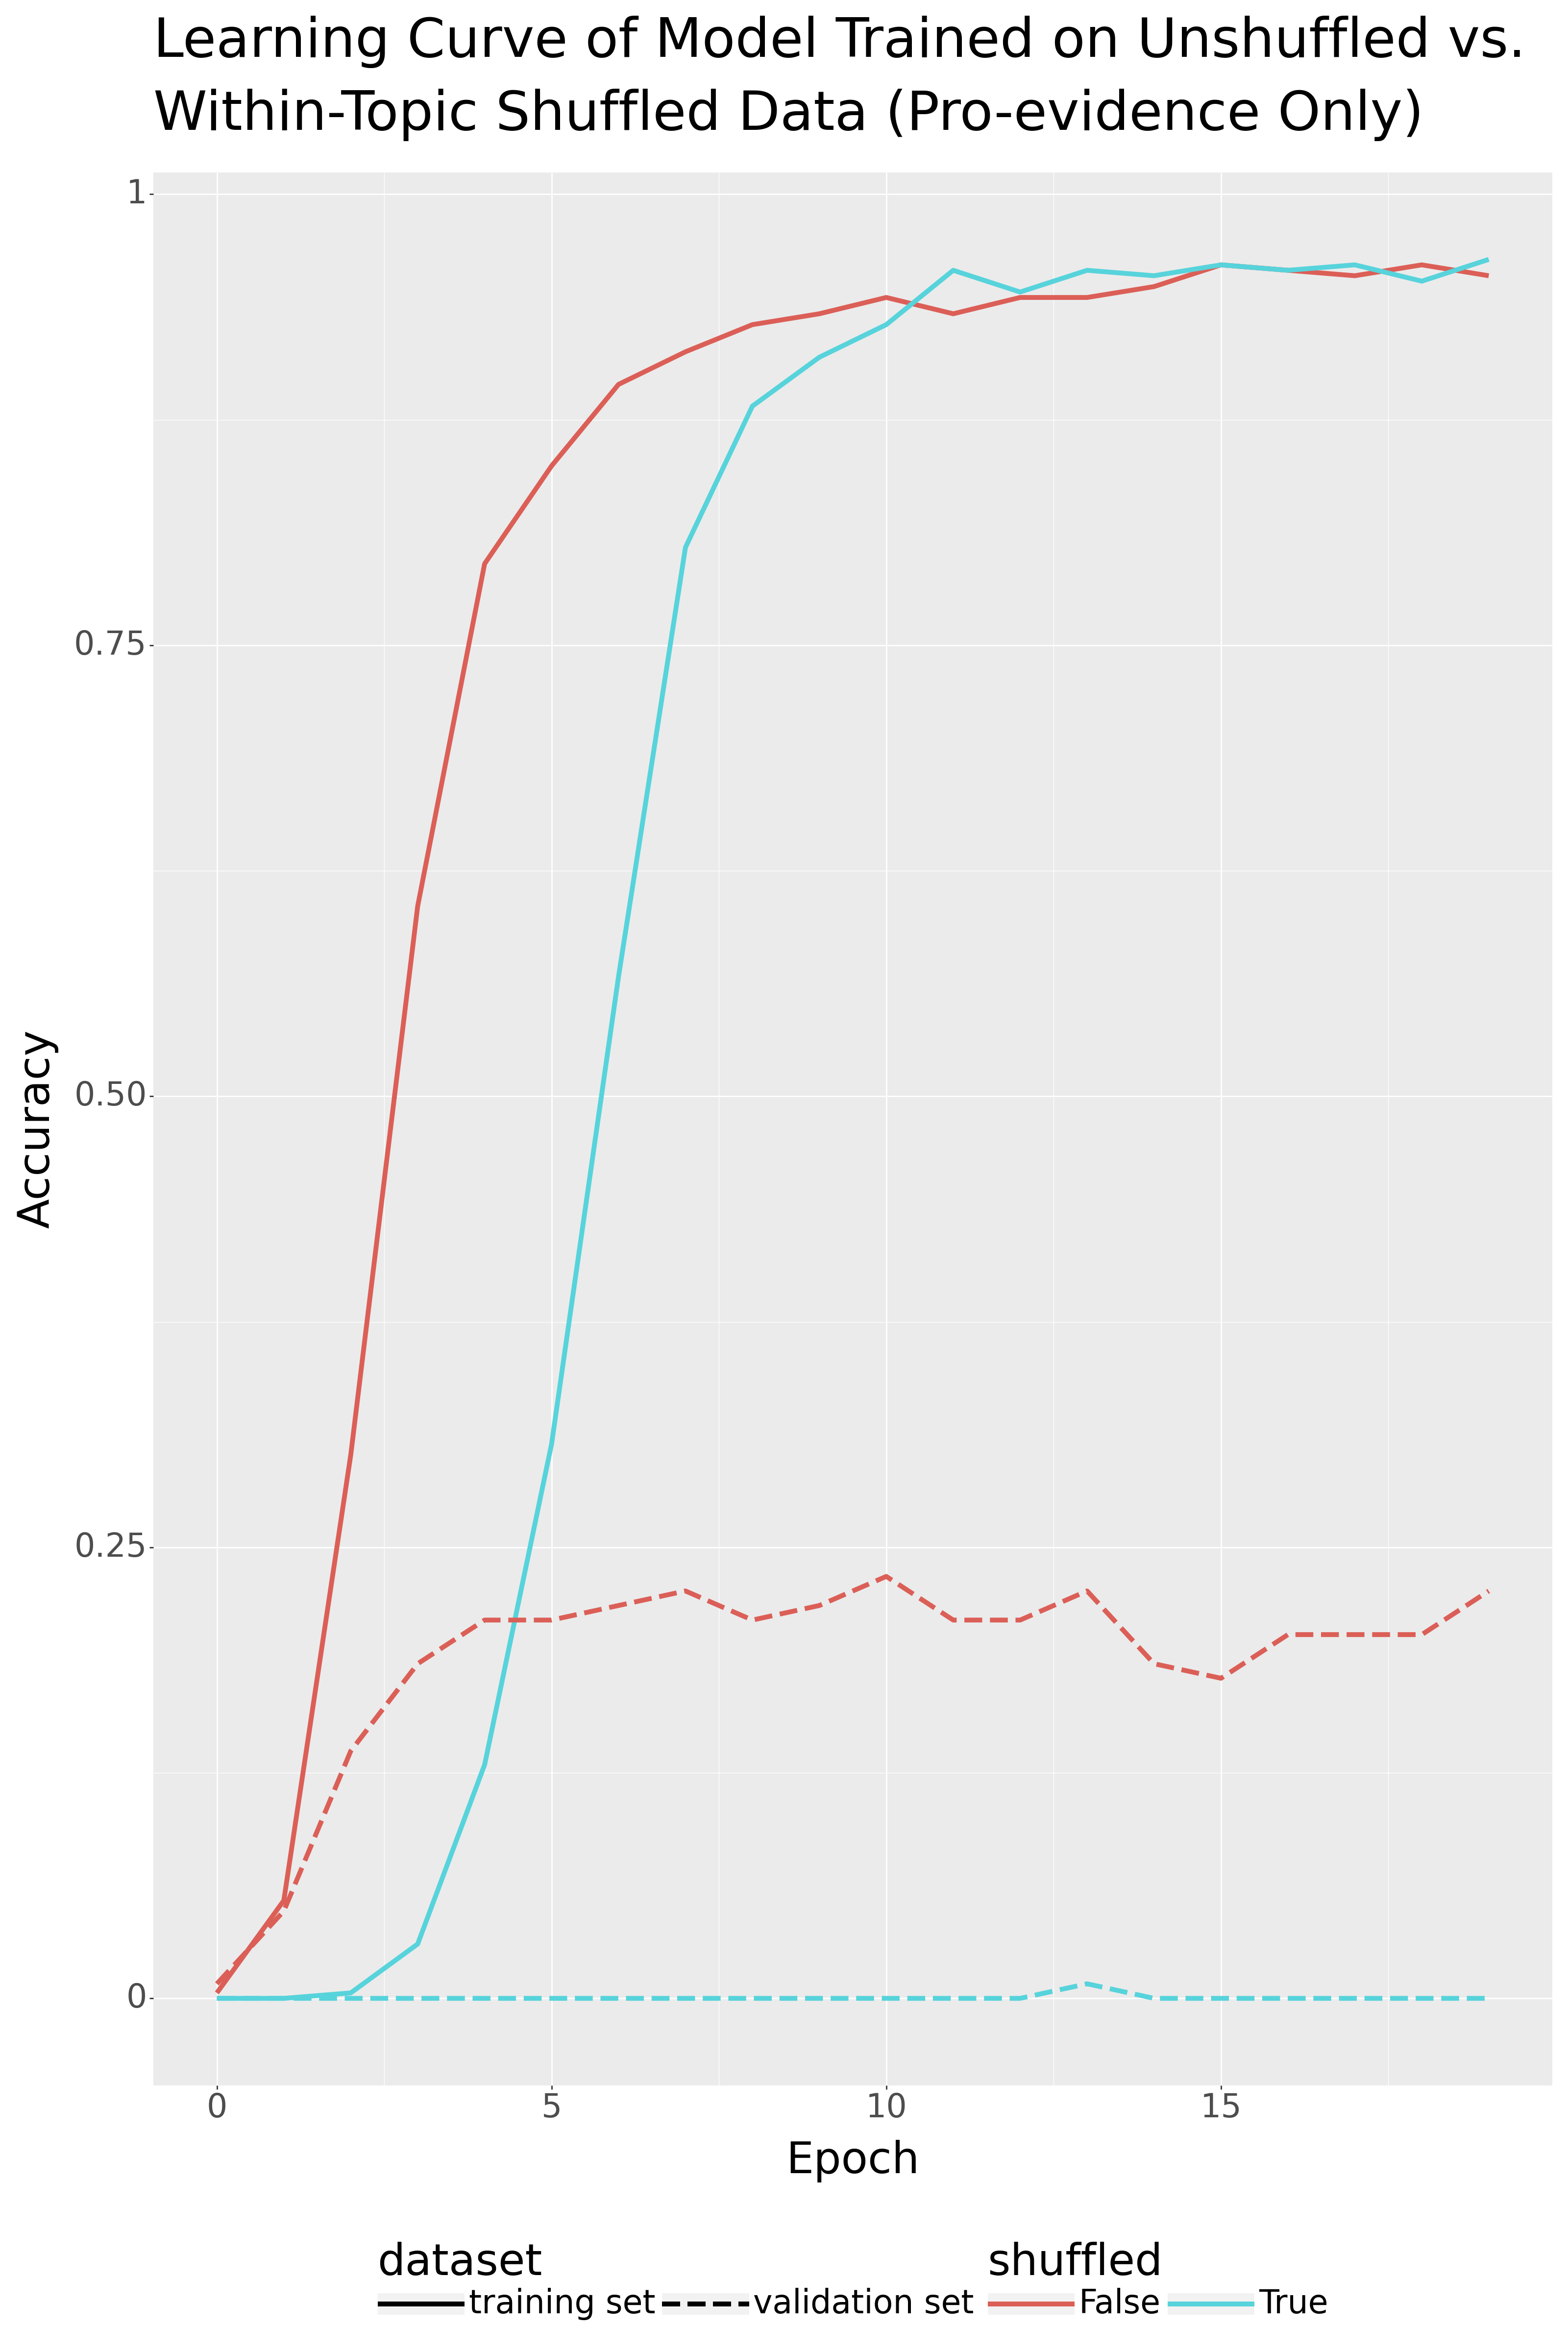

<Figure Size: (1600 x 2400)>

In [ ]:
pro_training_plot

## Counter Training Plots

In [ ]:
counter_training_df = pd.concat([loaded_counter_history, loaded_counter_shuffled_history])

In [ ]:
linetype_map = {'validation set': 'solid', 'training set': 'dashed'}

counter_training_plot = (
  ggplot(counter_training_df, aes(x='epoch', y='accuracy', linetype='dataset', color='shuffled')) +
  geom_line(size=2) +
  labs(title='Learning Curve of Model Trained on Unshuffled vs. Within-Topic Shuffled Data (Counterevidence Only)', x='Epoch', y='Accuracy') +
  scale_linetype_manual(linetype_map) +
  theme(
    figure_size=(16,24),
    axis_title=element_text(size=32),
    axis_text=element_text(size=24),
    legend_title=element_text(size=32, lineheight=1.5),
    legend_text=element_text(size=24, lineheight=1.5),
    plot_title=element_text(size=40, wrap=True, lineheight=1.5),
    legend_position="bottom",
    legend_key_width=64
  ) +
  guides(fill = guide_legend(byrow = True))
)
ggsave(counter_training_plot, "current-data-dump/ada002-autoencoder/counter_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/ada002-autoencoder/counter_training_plot.png


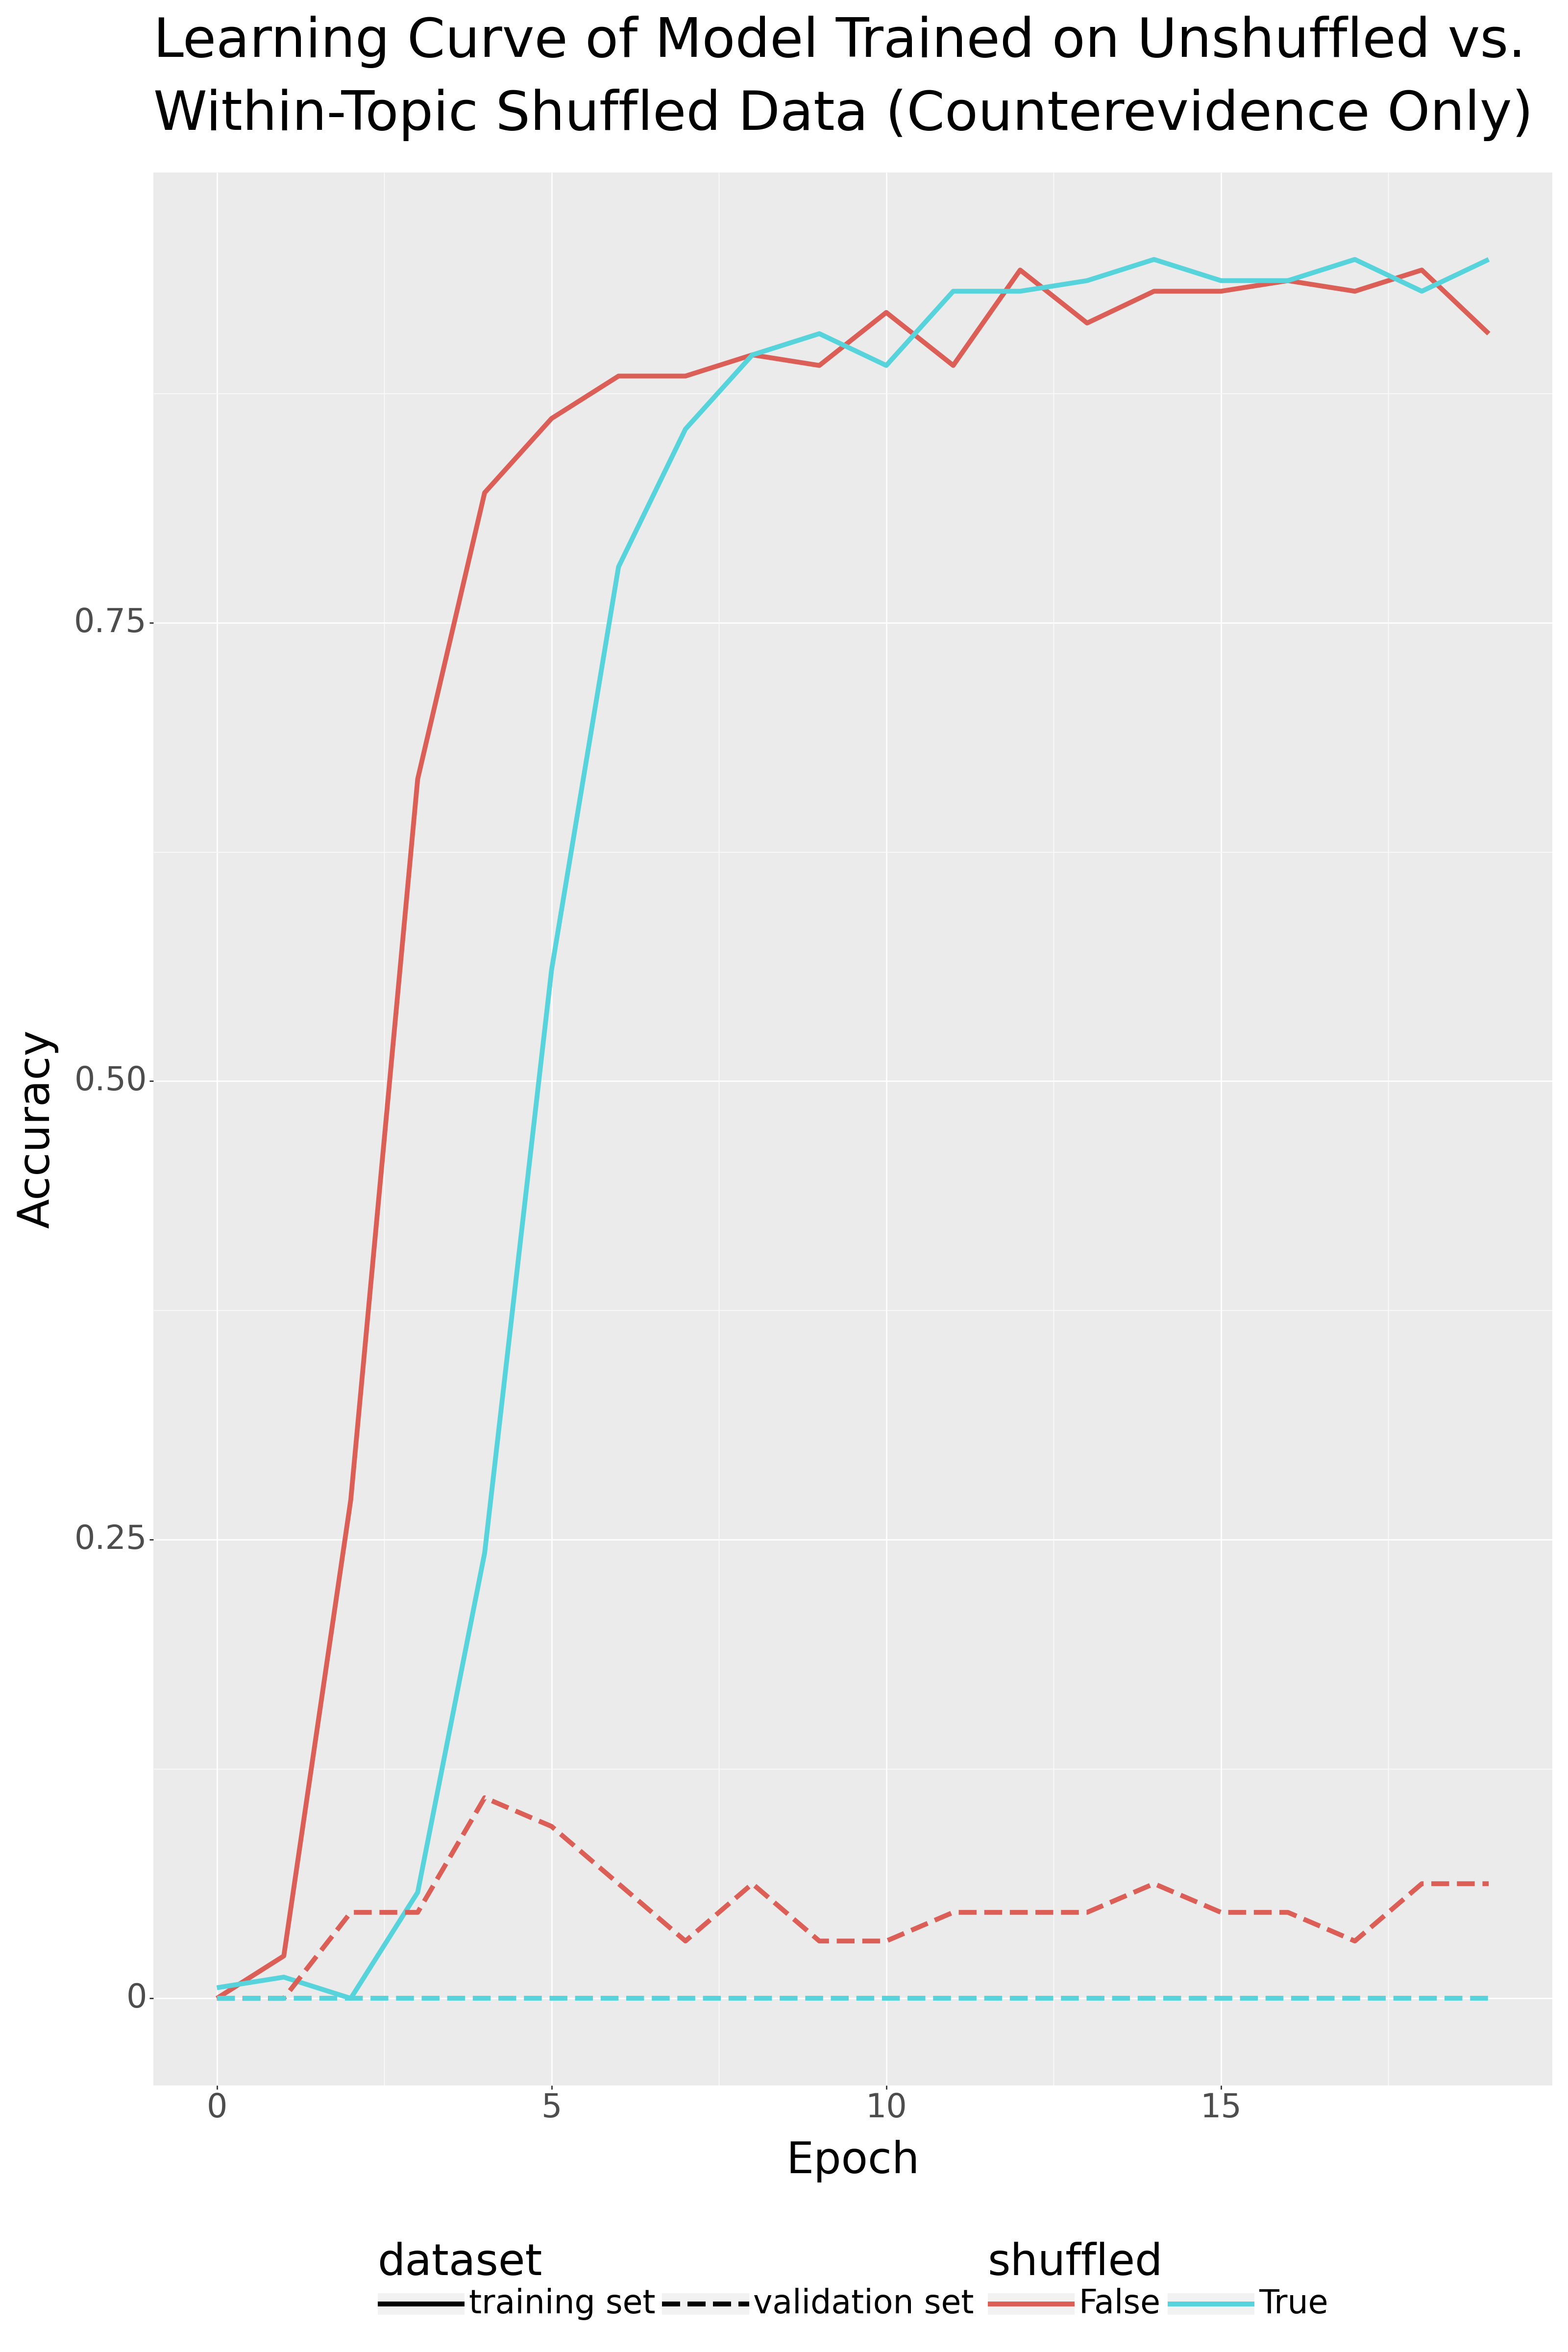

<Figure Size: (1600 x 2400)>

In [ ]:
counter_training_plot

## All Training Plots

In [ ]:
subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/ada002-scifact-autoencoder/ada002_scifact_autoencoder.zip", shell=True)
print("ada_autoencoder.zip successfully imported")
ada_autoencoder_file_path_zip = 'ada002_scifact_autoencoder.zip'
ada_autoencoder_file_path = 'current-data-dump/ada002-autoencoder'
os.makedirs(ada_autoencoder_file_path, exist_ok=True)
with zipfile.ZipFile(ada_autoencoder_file_path_zip, 'r') as zip_ref:
  zip_ref.extractall(ada_autoencoder_file_path)
extracted_files = os.listdir(ada_autoencoder_file_path)
print("Files extracted:", extracted_files)

ada_autoencoder.zip successfully imported
Files extracted: ['combined_shuffled_training_log.csv', 'pro_training_log.csv', 'counter_training_log.csv', 'counter_training_plot.png', 'all_shuffled_training_plot.png', 'y_train_combined.pkl', 'counter_shuffled_training_log.csv', 'combined_shuffled_training_plot.png', 'pro_shuffled_autoencoder_model.keras', 'combined_autoencoder_model.keras', 'pro_training_plot.png', 'x_train_combined.pkl', 'combined_training_plot.png', 'counter_shuffled_autoencoder_model.keras', 'counter_autoencoder_model.keras', 'pro_autoencoder_model.keras', 'combined_shuffled_autoencoder_model.keras', 'all_training_plot.png', 'combined_training_log.csv', 'pro_shuffled_training_log.csv']


In [ ]:
subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/ada003-scifact-autoencoder/ada003_scifact_autoencoder.zip", shell=True)
print("ada_autoencoder.zip successfully imported")
ada_autoencoder_file_path_zip = 'ada003_scifact_autoencoder.zip'
ada_autoencoder_file_path = 'current-data-dump/ada003-autoencoder'
os.makedirs(ada_autoencoder_file_path, exist_ok=True)
with zipfile.ZipFile(ada_autoencoder_file_path_zip, 'r') as zip_ref:
  zip_ref.extractall(ada_autoencoder_file_path)
extracted_files = os.listdir(ada_autoencoder_file_path)
print("Files extracted:", extracted_files)

ada_autoencoder.zip successfully imported
Files extracted: ['combined_shuffled_training_log.csv', 'pro_training_log.csv', 'counter_training_log.csv', 'counter_training_plot.png', 'all_shuffled_training_plot.png', 'y_train_combined.pkl', 'counter_shuffled_training_log.csv', 'pro_shuffled_training_plot.png', 'pro_shuffled_autoencoder_model.keras', 'combined_autoencoder_model.keras', 'pro_training_plot.png', 'combined_counter_training_plot.png', 'x_train_combined.pkl', 'combined_training_plot.png', 'counter_shuffled_autoencoder_model.keras', 'combined_pro_training_plot.png', 'counter_shuffled_training_plot.png', 'counter_autoencoder_model.keras', 'pro_autoencoder_model.keras', 'combined_shuffled_autoencoder_model.keras', 'all_training_plot.png', 'combined_training_log.csv', 'pro_shuffled_training_log.csv']


In [ ]:
subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/nomic-scifact-autoencoder/nomic_scifact_autoencoder.zip", shell=True)
print("ada_autoencoder.zip successfully imported")
ada_autoencoder_file_path_zip = 'nomic_scifact_autoencoder.zip'
ada_autoencoder_file_path = 'current-data-dump/nomic-autoencoder'
os.makedirs(ada_autoencoder_file_path, exist_ok=True)
with zipfile.ZipFile(ada_autoencoder_file_path_zip, 'r') as zip_ref:
  zip_ref.extractall(ada_autoencoder_file_path)
extracted_files = os.listdir(ada_autoencoder_file_path)
print("Files extracted:", extracted_files)

ada_autoencoder.zip successfully imported
Files extracted: ['combined_shuffled_training_log.csv', 'pro_training_log.csv', 'counter_training_log.csv', 'counter_training_plot.png', 'y_train_combined.pkl', 'counter_shuffled_training_log.csv', 'pro_shuffled_training_plot.png', 'combined_shuffled_training_plot.png', 'pro_shuffled_autoencoder_model.keras', 'combined_autoencoder_model.keras', 'pro_training_plot.png', 'x_train_combined.pkl', 'combined_training_plot.png', 'all_pro_training_plot.png', 'counter_shuffled_autoencoder_model.keras', 'counter_shuffled_training_plot.png', 'counter_autoencoder_model.keras', 'all_combined_training_plot.png', 'pro_autoencoder_model.keras', 'combined_shuffled_autoencoder_model.keras', 'all_training_plot.png', 'all_counter_training_plot.png', 'combined_training_log.csv', 'pro_shuffled_training_log.csv']


In [ ]:
ada002_training_log = pd.read_csv('current-data-dump/ada002-autoencoder/counter_shuffled_training_log.csv')
ada003_training_log = pd.read_csv('current-data-dump/ada003-autoencoder/counter_shuffled_training_log.csv')
nomic_training_log = pd.read_csv('current-data-dump/nomic-autoencoder/counter_shuffled_training_log.csv')

In [ ]:
ada002_training_log = ada002_training_log.rename(columns={'Unnamed: 0': 'epoch', 'metric_choose_argument_counter_y_train': 'training set', 'val_metric_choose_argument_counter_y_train': 'validation set'})
ada003_training_log = ada003_training_log.rename(columns={'Unnamed: 0': 'epoch', 'metric_choose_argument_counter_y_train': 'training set', 'val_metric_choose_argument_counter_y_train': 'validation set'})
nomic_training_log = nomic_training_log.rename(columns={'Unnamed: 0': 'epoch', 'metric_choose_argument_counter_y_train': 'training set', 'val_metric_choose_argument_counter_y_train': 'validation set'})

In [ ]:
ada002_training_log = pd.melt(ada002_training_log, id_vars = ['epoch'], value_vars = ['training set', 'validation set'])
ada002_training_log['model'] = 'ada002'
ada003_training_log = pd.melt(ada003_training_log, id_vars = ['epoch'], value_vars = ['training set', 'validation set'])
ada003_training_log['model'] = 'ada003'
nomic_training_log = pd.melt(nomic_training_log, id_vars = ['epoch'], value_vars = ['training set', 'validation set'])
nomic_training_log['model'] = 'nomic'

In [ ]:
all_df = pd.concat([ada002_training_log, ada003_training_log, nomic_training_log])

In [ ]:
all_df = all_df.rename(columns={'variable': 'dataset', 'value': 'accuracy'})

In [ ]:
color_map = {'ada002': 'blue', 'ada003': 'red', 'nomic': 'green'}
linetype_map = {'validation set': 'solid', 'training set': 'dashed'}

combined_all_plot = (
  ggplot(all_df, aes(x='epoch', y='accuracy', linetype='dataset', color='model')) +
  geom_line(size=2) +
  labs(title='Learning Curve of Networks Trained on Scifact Training Data (Shuffled; Counterevidence Only)', x='Epoch', y='Accuracy') +
  scale_color_manual(color_map) +
  scale_linetype_manual(linetype_map) +
  theme(
    figure_size=(16,24),
    axis_title=element_text(size=32, lineheight=1.5),
    axis_text=element_text(size=24),
    legend_title=element_text(size=32, lineheight=1.5),
    legend_text=element_text(size=24, lineheight=1.5),
    plot_title=element_text(size=40, wrap=True, lineheight=1.5),
    legend_position="bottom",
    legend_key_width=64
  ) +
  guides(fill = guide_legend(byrow = True))
)

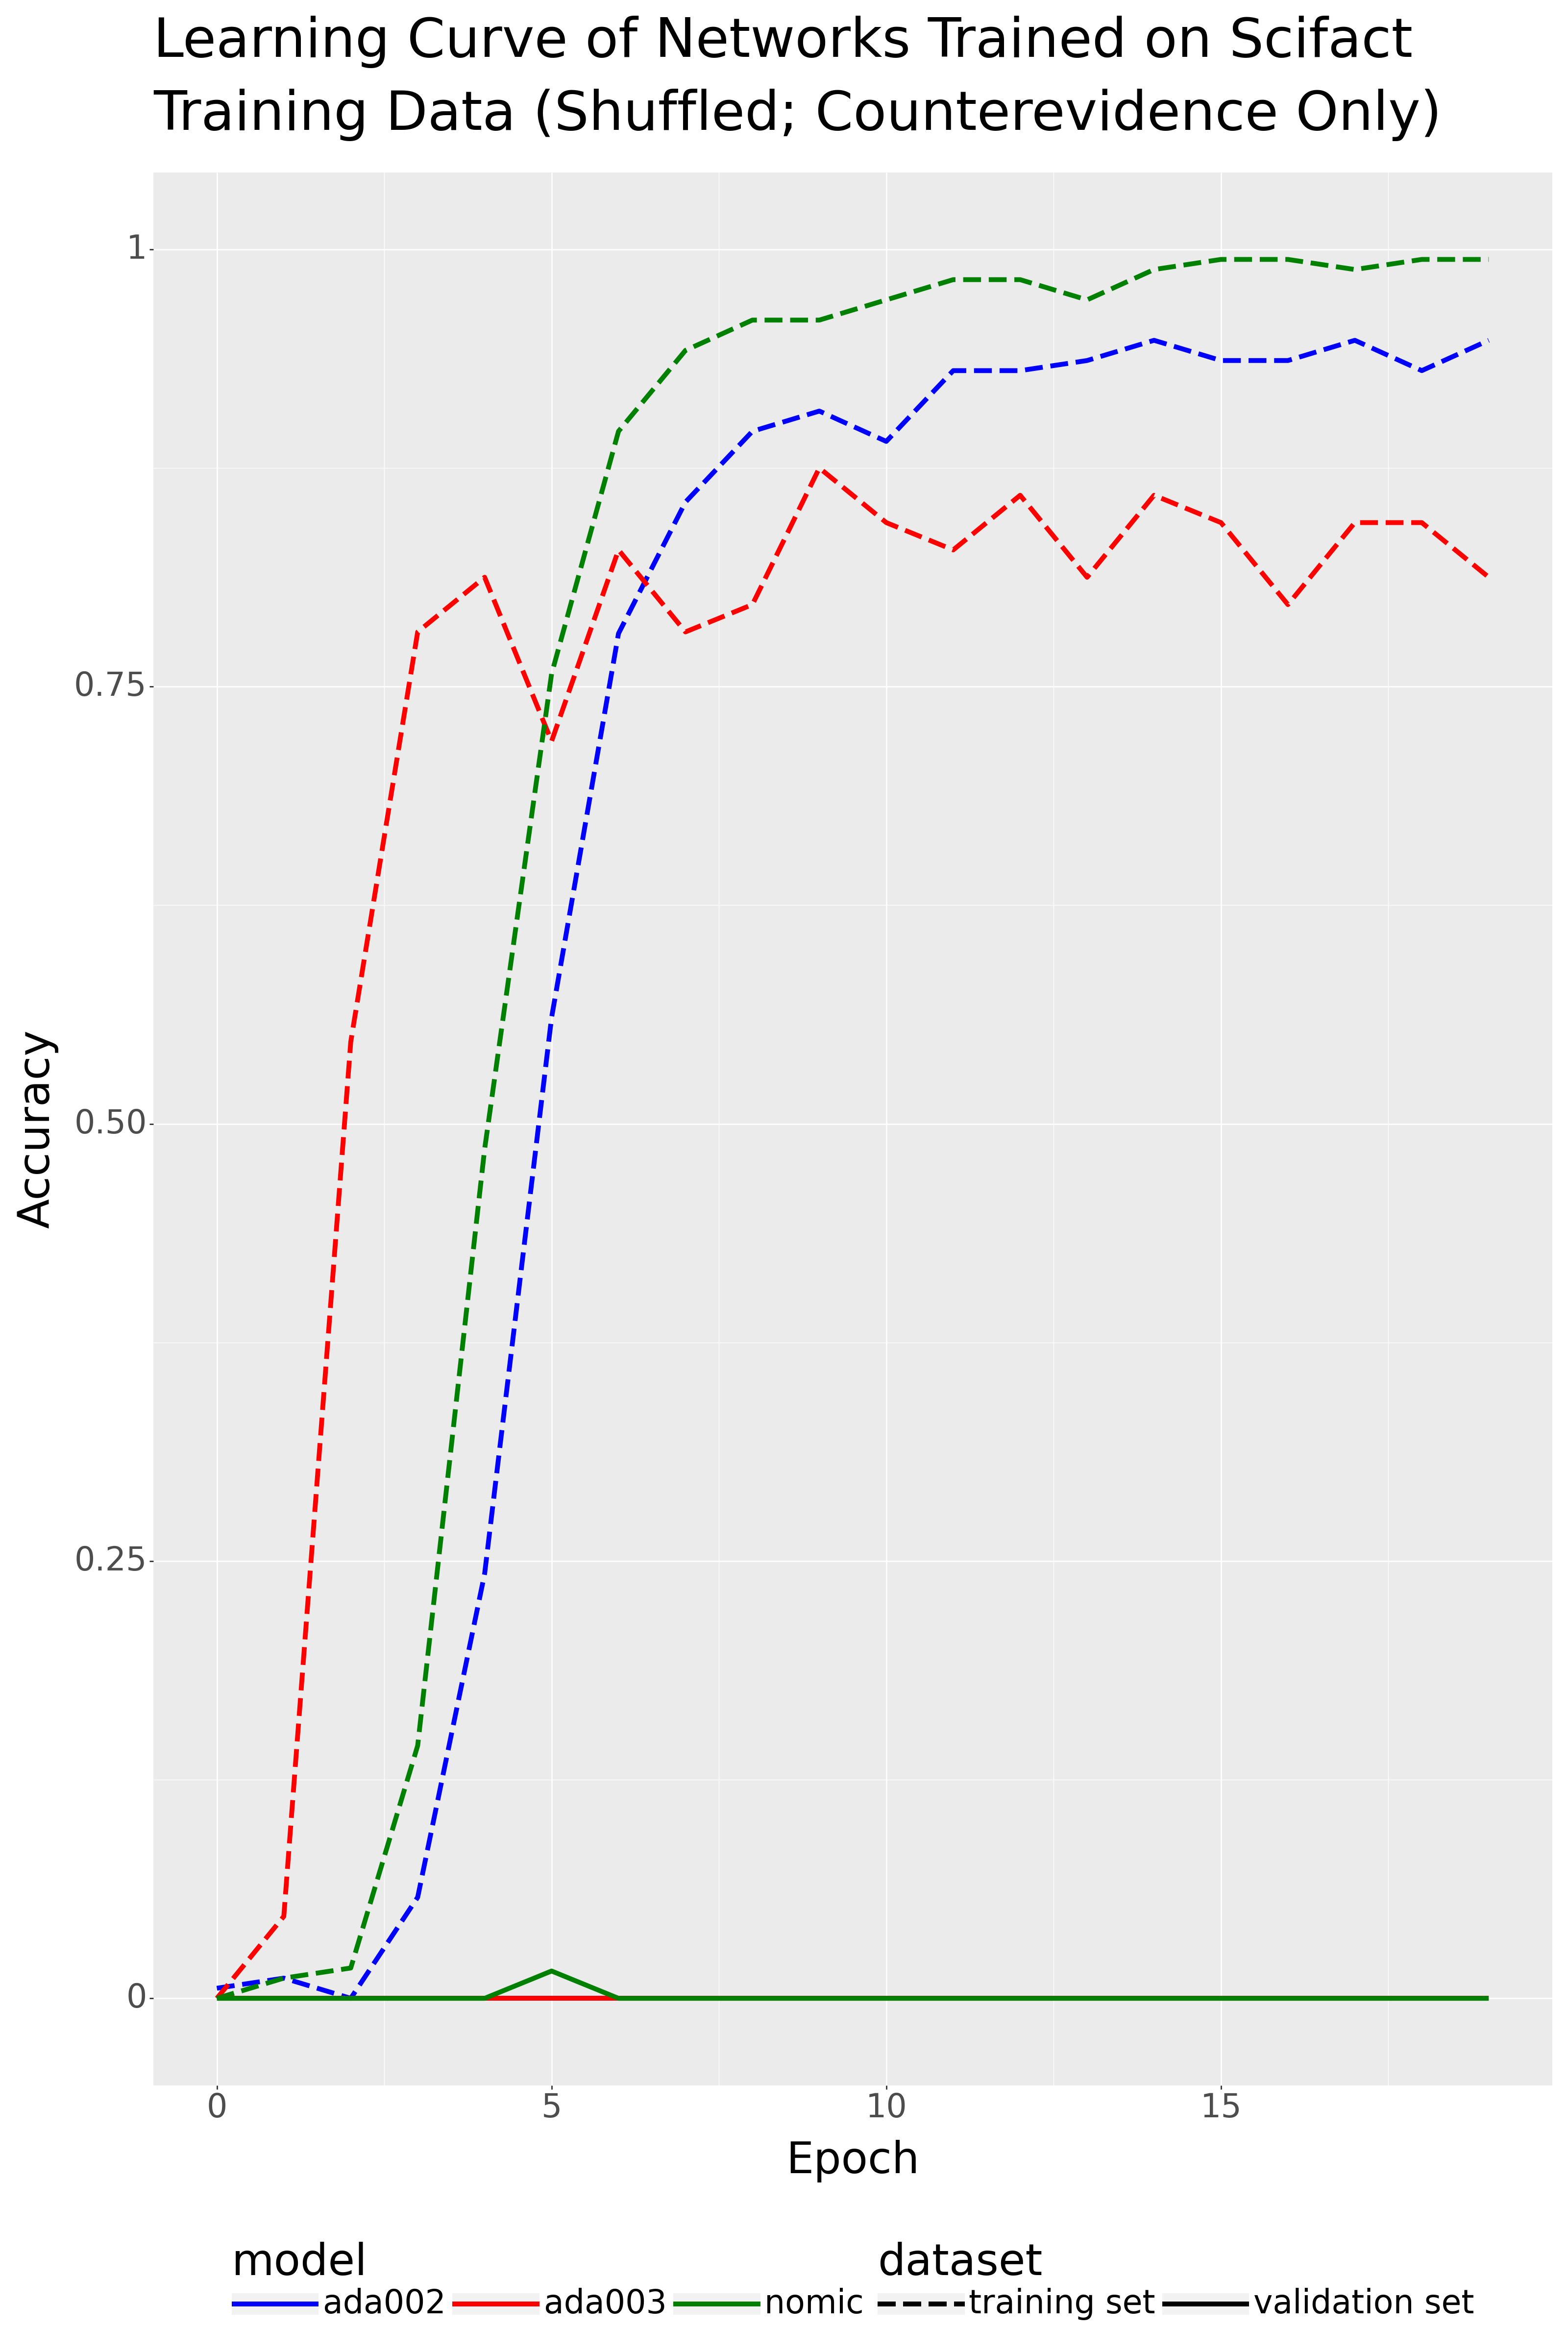

<Figure Size: (1600 x 2400)>

In [ ]:
combined_all_plot

## Final Export

In [ ]:
export_ada_autoencoder()

Zip file created at: current-data-dump/nomic-autoencoder

File: current-data-dump/nomic-autoencoder uploaded at osfstorage
